Comparing features:
- features as is
- features including no-show rate, reschedue, follow-up

Comparing models for two versions:
- LR
- KNN
- SVC
- RFC

Comparing models with oversampling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import calendar
import pickle

%matplotlib inline
plt.style.use('seaborn-pastel')

import seaborn as sns
sns.set(style="whitegrid")

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, roc_curve

%run evaluation_functions.py

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, 
                              AdaBoostClassifier, BaggingRegressor)

In [3]:
with open('pickles/appt.pickle','rb') as read_file:
    appt = pickle.load(read_file)
with open('pickles/appt_v2.pickle','rb') as read_file:
    appt_v2 = pickle.load(read_file)
with open('pickles/appt_v2_all0.pickle','rb') as read_file:
    appt_v3 = pickle.load(read_file)
with open('pickles/appt_v2_all1.pickle','rb') as read_file:
    appt_v4 = pickle.load(read_file)

In [4]:
#Set features
# run for appt - all appts, basic features
feature_cols = ['Gender','Age','Scholarship','Hipertension','Diabetes','Alcoholism','Handcap','SMS_received',
                'ApptDayofWeek','SchedDayofWeek','Neighbourhood','DayDiff']
a_Xv1 = appt[feature_cols]
a_Xv1 = pd.get_dummies(a_Xv1, columns = ['Gender','Neighbourhood','ApptDayofWeek','SchedDayofWeek'])
a_Xv1.drop(columns=['Gender_F','Neighbourhood_VILA RUBIM','SchedDayofWeek_Monday','ApptDayofWeek_Monday'],inplace=True)
Xv1_cols = np.array(a_Xv1.columns)
a_Xv1.info()

## run for appt_v2 - second or more appts, adds historical features
feature_cols = ['Gender','Age2','Neighbourhood2','Scholarship','Hipertension','Diabetes','Alcoholism',
                'Handcap_bin','SMS_received','SchedDayofWeek','ApptDayofWeek','DayDiff2',
                'no_show_rate2','Reschedule','Follow_up']
a_Xv2 = appt_v2[feature_cols]
a_Xv2 = pd.get_dummies(a_Xv2, columns = ['Gender','Neighbourhood2','SchedDayofWeek','ApptDayofWeek'])
a_Xv2.drop(columns=['Gender_F','Neighbourhood2_OTHER','SchedDayofWeek_Monday','ApptDayofWeek_Monday'],inplace=True)
Xv2_cols = np.array(a_Xv2.columns)
a_Xv2.info()
# a_X.head(5)

## run for appt_v2_all0 - all appts, replaces no-show-rate NA's as 0's
feature_cols = ['Gender','Age2','Neighbourhood2','Scholarship','Hipertension','Diabetes','Alcoholism',
                'Handcap_bin','SMS_received','SchedDayofWeek','ApptDayofWeek','DayDiff2',
                'no_show_rate2','Reschedule','Follow_up']
a_Xv3 = appt_v3[feature_cols]
a_Xv3 = pd.get_dummies(a_Xv3, columns = ['Gender','Neighbourhood2','SchedDayofWeek','ApptDayofWeek'])
a_Xv3.drop(columns=['Gender_F','Neighbourhood2_OTHER','SchedDayofWeek_Monday','ApptDayofWeek_Monday'],inplace=True)
Xv3_cols = np.array(a_Xv3.columns)
a_Xv3.info()

## run for appt_v2_all1 - all appts, replaces no-show-rate NA's as imputed from linreg's
feature_cols = ['Gender','Age2','Neighbourhood2','Scholarship','Hipertension','Diabetes','Alcoholism',
                'Handcap_bin','SMS_received','SchedDayofWeek','ApptDayofWeek','DayDiff2',
                'no_show_rate2','Reschedule','Follow_up']
a_Xv4 = appt_v4[feature_cols]
a_Xv4 = pd.get_dummies(a_Xv4, columns = ['Gender','Neighbourhood2','SchedDayofWeek','ApptDayofWeek'])
a_Xv4.drop(columns=['Gender_F','Neighbourhood2_OTHER','SchedDayofWeek_Monday','ApptDayofWeek_Monday'],inplace=True)
Xv4_cols = np.array(a_Xv4.columns)
a_Xv4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71163 entries, 0 to 71958
Data columns (total 97 columns):
Age                                          71163 non-null int64
Scholarship                                  71163 non-null int64
Hipertension                                 71163 non-null int64
Diabetes                                     71163 non-null int64
Alcoholism                                   71163 non-null int64
Handcap                                      71163 non-null int64
SMS_received                                 71163 non-null int64
DayDiff                                      71163 non-null int64
Gender_M                                     71163 non-null uint8
Neighbourhood_AEROPORTO                      71163 non-null uint8
Neighbourhood_ANDORINHAS                     71163 non-null uint8
Neighbourhood_ANTÔNIO HONÓRIO                71163 non-null uint8
Neighbourhood_ARIOVALDO FAVALESSA            71163 non-null uint8
Neighbourhood_BARRO VERMELHO     

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71163 entries, 65088 to 68006
Data columns (total 85 columns):
Age2                                  71163 non-null int64
Scholarship                           71163 non-null int64
Hipertension                          71163 non-null int64
Diabetes                              71163 non-null int64
Alcoholism                            71163 non-null int64
Handcap_bin                           71163 non-null int64
SMS_received                          71163 non-null int64
DayDiff2                              71163 non-null int64
no_show_rate2                         71163 non-null float64
Reschedule                            71163 non-null int64
Follow_up                             71163 non-null int64
Gender_M                              71163 non-null uint8
Neighbourhood2_ANDORINHAS             71163 non-null uint8
Neighbourhood2_BARRO VERMELHO         71163 non-null uint8
Neighbourhood2_BELA VISTA             71163 non-null uint8


In [5]:
# split into training and test sets

#appt
Xv1, yv1 = a_Xv1, appt['No_show_num']
Xv1_train, Xv1_test, yv1_train, yv1_test = train_test_split(Xv1, yv1, test_size = 0.25, random_state = 10, stratify = yv1)
#appt_v2
Xv2, yv2 = a_Xv2, appt_v2['No_show_num']
Xv2_train, Xv2_test, yv2_train, yv2_test = train_test_split(Xv2, yv2, test_size = 0.25, random_state = 10, stratify = yv2)
#appt_v3
Xv3, yv3 = a_Xv3, appt_v3['No_show_num']
Xv3_train, Xv3_test, yv3_train, yv3_test = train_test_split(Xv3, yv3, test_size = 0.25, random_state = 10, stratify = yv3)
#appt_v4
Xv4, yv4 = a_Xv4, appt_v4['No_show_num']
Xv4_train, Xv4_test, yv4_train, yv4_test = train_test_split(Xv4, yv4, test_size = 0.25, random_state = 10, stratify = yv4)


In [6]:
# create standardized versions for LR, KNN, and SVC
#Standardize
def stan(X_train,X_test):
    std = StandardScaler()
    std.fit(X_train)
    return std.transform(X_train), std.transform(X_test)

Xv1_train_std, Xv1_test_std = stan(Xv1_train,Xv1_test)
Xv2_train_std, Xv2_test_std = stan(Xv2_train,Xv2_test)
Xv3_train_std, Xv3_test_std = stan(Xv3_train,Xv3_test)
Xv4_train_std, Xv4_test_std = stan(Xv4_train,Xv4_test)

### Models
skipping Decision Trees and Naive Bayes
#### Logistic Regression

In [7]:
def fit_LR(X_train,y_train,X_test):
    LR = LogisticRegression(solver='liblinear')
    LR.fit(X_train,y_train)
    return LR.predict(X_test), LR.predict_proba(X_test)[:,1]

In [8]:
yv1_test_LR, yv1_test_LR_prob = fit_LR(Xv1_train_std,yv1_train,Xv1_test_std)
yv2_test_LR, yv2_test_LR_prob = fit_LR(Xv2_train_std,yv2_train,Xv2_test_std)
yv3_test_LR, yv3_test_LR_prob = fit_LR(Xv3_train_std,yv3_train,Xv3_test_std)
yv4_test_LR, yv4_test_LR_prob = fit_LR(Xv4_train_std,yv4_train,Xv4_test_std)

In [9]:
print_scores(yv1_test,yv1_test_LR)

Accuracy score: 0.7164858636389185
F1 score: 0.011368090944727556
Precision (true + / all predicted +): 0.4142857142857143
Recall (true + / all actual +): 0.005763116057233704


In [10]:
print_scores(yv2_test,yv2_test_LR)

Accuracy score: 0.7353865493400377
F1 score: 0.2846219201359388
Precision (true + / all predicted +): 0.5866900175131349
Recall (true + / all actual +): 0.1878855860908581


In [11]:
print_scores(yv3_test,yv3_test_LR)

Accuracy score: 0.7200269799336744
F1 score: 0.10878511361603148
Precision (true + / all predicted +): 0.5457809694793537
Recall (true + / all actual +): 0.06041335453100159


In [12]:
print_scores(yv4_test,yv4_test_LR)

Accuracy score: 0.7194086897869709
F1 score: 0.11926605504587158
Precision (true + / all predicted +): 0.5314465408805031
Recall (true + / all actual +): 0.06717011128775835


#### KNN

In [13]:
def fit_KNN(X_train,y_train,X_test):
    KNN = KNeighborsClassifier(n_neighbors=30)
    KNN.fit(X_train,y_train)
    return KNN.predict(X_test), KNN.predict_proba(X_test)[:,1]

In [14]:
yv1_test_KNN, yv1_test_KNN_prob = fit_KNN(Xv1_train_std,yv1_train,Xv1_test_std)
yv2_test_KNN, yv2_test_KNN_prob = fit_KNN(Xv2_train_std,yv2_train,Xv2_test_std)
yv3_test_KNN, yv3_test_KNN_prob = fit_KNN(Xv3_train_std,yv3_train,Xv3_test_std)

In [15]:
print_scores(yv1_test,yv1_test_KNN)

Accuracy score: 0.7166544882243832
F1 score: 0.0638811513463324
Precision (true + / all predicted +): 0.48725212464589235
Recall (true + / all actual +): 0.03418124006359301


In [16]:
print_scores(yv2_test,yv2_test_KNN)

Accuracy score: 0.7280012570710245
F1 score: 0.12531581606872155
Precision (true + / all predicted +): 0.6326530612244898
Recall (true + / all actual +): 0.06954570947840717


In [17]:
print_scores(yv3_test,yv3_test_KNN)

Accuracy score: 0.7187903996402676
F1 score: 0.0925086159985489
Precision (true + / all predicted +): 0.5301455301455301
Recall (true + / all actual +): 0.05067567567567568


#### SVC

In [18]:
def fit_SVC(X_train,y_train,X_test):
    SVCmodel = SVC()
    SVCmodel.fit(X_train,y_train)
    return SVCmodel.predict(X_test)

In [19]:
# takes about 10-15 minutes
# yv1_test_SVC = fit_SVC(Xv1_train_std,yv1_train,Xv1_test_std)
# yv2_test_SVC = fit_SVC(Xv2_train_std,yv2_train,Xv2_test_std)

In [20]:
# print_scores(yv1_test,yv1_test_SVC)

In [21]:
# print_scores(yv2_test,yv2_test_SVC)

#### Random Forests

In [22]:
def fit_RFC(X_train,y_train,X_test):
    RFC = RandomForestClassifier(n_estimators=100,random_state=88)
    RFC.fit(X_train,y_train)
    return RFC.predict(X_test), RFC.predict_proba(X_test)[:,1]

In [23]:
yv1_test_RFC, yv1_test_RFC_prob = fit_RFC(Xv1_train,yv1_train,Xv1_test)
yv2_test_RFC, yv2_test_RFC_prob = fit_RFC(Xv2_train,yv2_train,Xv2_test)
yv3_test_RFC, yv3_test_RFC_prob = fit_RFC(Xv3_train,yv3_train,Xv3_test)
yv4_test_RFC, yv4_test_RFC_prob = fit_RFC(Xv4_train,yv4_train,Xv4_test)
# yv3_test_RFC = fit_RFC(Xv3_train,yv3_train,Xv3_test)

In [24]:
print_scores(yv1_test,yv1_test_RFC)

Accuracy score: 0.6981619920184363
F1 score: 0.26357652221612726
Precision (true + / all predicted +): 0.4252212389380531
Recall (true + / all actual +): 0.19097774244833068


In [25]:
print_scores(yv2_test,yv2_test_RFC)

Accuracy score: 0.7280012570710245
F1 score: 0.3246195864221615
Precision (true + / all predicted +): 0.5333333333333333
Recall (true + / all actual +): 0.2333146382501402


In [26]:
print_scores(yv3_test,yv3_test_RFC)

Accuracy score: 0.7022651902647405
F1 score: 0.2627696590118302
Precision (true + / all predicted +): 0.4384579656293544
Recall (true + / all actual +): 0.1875993640699523


In [27]:
print_scores(yv4_test,yv4_test_RFC)

Accuracy score: 0.7103591703670395
F1 score: 0.25631404243036515
Precision (true + / all predicted +): 0.4681075382182393
Recall (true + / all actual +): 0.17647058823529413


#### XGBoost

In [28]:
def fit_XGB(X_train,y_train,X_test):
    XGB = XGBClassifier()
    XGB.fit(X_train,y_train)
    return XGB.predict(X_test), XGB.predict_proba(X_test)[:,1]

In [29]:
yv1_test_XGB, yv1_test_XGB_prob = fit_XGB(Xv1_train,yv1_train,Xv1_test)
yv2_test_XGB, yv2_test_XGB_prob = fit_XGB(Xv2_train,yv2_train,Xv2_test)
yv3_test_XGB, yv3_test_XGB_prob = fit_XGB(Xv3_train,yv3_train,Xv3_test)
yv4_test_XGB, yv4_test_XGB_prob = fit_XGB(Xv4_train,yv4_train,Xv4_test)

In [30]:
print_scores(yv1_test,yv1_test_XGB)

Accuracy score: 0.717834860322635
F1 score: 0.016072128577028614
Precision (true + / all predicted +): 0.5857142857142857
Recall (true + / all actual +): 0.00814785373608903


In [31]:
print_scores(yv2_test,yv2_test_XGB)

Accuracy score: 0.7382149591451918
F1 score: 0.2718531468531468
Precision (true + / all predicted +): 0.6158415841584158
Recall (true + / all actual +): 0.17442512619181155


In [32]:
print_scores(yv3_test,yv3_test_XGB)

Accuracy score: 0.7244112191557529
F1 score: 0.10447488584474887
Precision (true + / all predicted +): 0.6455981941309256
Recall (true + / all actual +): 0.0568362480127186


In [33]:
print_scores(yv4_test,yv4_test_XGB)

Accuracy score: 0.7225563487156428
F1 score: 0.11159107271418287
Precision (true + / all predicted +): 0.5916030534351145
Recall (true + / all actual +): 0.06160572337042925


### Oversampling - v2
Use RandomOverSampler after analysis from workbook 4

In [153]:
# Now add some random oversampling of the minority classes
from collections import Counter
from imblearn.over_sampling import RandomOverSampler,SMOTE, ADASYN

ros = RandomOverSampler(random_state=42)
# ros = SMOTE(random_state=42)
# ros = ADASYN(random_state=42)
Xv2_resampled, yv2_resampled = ros.fit_sample(Xv2_train,yv2_train)
Xv2_resampled = pd.DataFrame(Xv2_resampled,columns=Xv2_train.columns)
Counter(yv2_resampled)

Xv3_resampled, yv3_resampled = ros.fit_sample(Xv3_train,yv3_train)
Xv3_resampled = pd.DataFrame(Xv3_resampled,columns=Xv3_train.columns)
Counter(yv3_resampled)

Xv4_resampled, yv4_resampled = ros.fit_sample(Xv4_train,yv4_train)
Xv4_resampled = pd.DataFrame(Xv4_resampled,columns=Xv4_train.columns)
Counter(yv4_resampled)


Counter({0: 38276, 1: 37055})

#### Logistic Regression

In [154]:
LR = LogisticRegression(solver='liblinear')
LR.fit(Xv2_resampled,yv2_resampled)
yv2_test_LR_o = LR.predict(Xv2_test)
yv2_test_LR_o_prob = LR.predict_proba(Xv2_test)[:,1]

In [155]:
print_scores(yv2_test,yv2_test_LR_o)

Accuracy score: 0.6588623507228158
F1 score: 0.4541111390495348
Precision (true + / all predicted +): 0.41157702825888787
Recall (true + / all actual +): 0.5064498037016265


In [156]:
LR.fit(Xv3_resampled,yv3_resampled)
yv3_test_LR_o = LR.predict(Xv3_test)
yv3_test_LR_o_prob = LR.predict_proba(Xv3_test)[:,1]
print_scores(yv3_test,yv3_test_LR_o)

Accuracy score: 0.5983362374234164
F1 score: 0.424174053182917
Precision (true + / all predicted +): 0.3567362428842505
Recall (true + / all actual +): 0.5230524642289348


In [157]:
LR.fit(Xv4_resampled,yv4_resampled)
yv4_test_LR_o = LR.predict(Xv4_test)
yv4_test_LR_o_prob = LR.predict_proba(Xv4_test)[:,1]
print_scores(yv4_test,yv4_test_LR_o)

Accuracy score: 0.6105896239671744
F1 score: 0.4334314687602225
Precision (true + / all predicted +): 0.368260144524736
Recall (true + / all actual +): 0.5266295707472178


#### RFC

In [142]:
RFC = RandomForestClassifier(n_estimators=100,random_state=88)
RFC.fit(Xv2_resampled,yv2_resampled)
yv2_test_RFC_o = RFC.predict(Xv2_test)
yv2_test_RFC_o_prob = RFC.predict_proba(Xv2_test)[:,1]

In [143]:
print_scores(yv2_test,yv2_test_RFC_o)

Accuracy score: 0.7177875549968573
F1 score: 0.3520923520923521
Precision (true + / all predicted +): 0.49342770475227504
Recall (true + / all actual +): 0.2736960179472799


In [144]:
RFC.fit(Xv3_resampled,yv3_resampled)
yv3_test_RFC_o = RFC.predict(Xv3_test)
yv3_test_RFC_o_prob = RFC.predict_proba(Xv3_test)[:,1]
print_scores(yv3_test,yv3_test_RFC_o)

Accuracy score: 0.6896183463548985
F1 score: 0.28876867594023703
Precision (true + / all predicted +): 0.4103221083455344
Recall (true + / all actual +): 0.22277424483306837


In [145]:
RFC.fit(Xv4_resampled,yv4_resampled)
yv4_test_RFC_o = RFC.predict(Xv4_test)
yv4_test_RFC_o_prob = RFC.predict_proba(Xv4_test)[:,1]
print_scores(yv4_test,yv4_test_RFC_o)

Accuracy score: 0.7002979034343207
F1 score: 0.2922750199097425
Precision (true + / all predicted +): 0.44004796163069543
Recall (true + / all actual +): 0.21879968203497616


#### XGBoost

In [146]:
XGB = XGBClassifier(random_state=43)
XGB.fit(Xv2_resampled,yv2_resampled)
yv2_test_XGB_o = XGB.predict(Xv2_test)
yv2_test_XGB_o_prob = XGB.predict_proba(Xv2_test)[:,1]

In [147]:
print_scores(yv2_test,yv2_test_XGB_o)

Accuracy score: 0.7163733500942804
F1 score: 0.3928691557349479
Precision (true + / all predicted +): 0.4907563025210084
Recall (true + / all actual +): 0.3275378575434661


In [148]:
XGB = XGBClassifier(random_state=43)
XGB.fit(Xv3_resampled,yv3_resampled)
yv3_test_XGB_o = XGB.predict(Xv3_test)
yv3_test_XGB_o_prob = XGB.predict_proba(Xv3_test)[:,1]

In [149]:
print_scores(yv3_test,yv3_test_XGB_o)

Accuracy score: 0.7056938901691867
F1 score: 0.21239470517448858
Precision (true + / all predicted +): 0.4368811881188119
Recall (true + / all actual +): 0.140302066772655


In [150]:
XGB = XGBClassifier(random_state=43)
XGB.fit(Xv4_resampled,yv4_resampled)
yv4_test_XGB_o = XGB.predict(Xv4_test)
yv4_test_XGB_o_prob = XGB.predict_proba(Xv4_test)[:,1]

In [151]:
print_scores(yv4_test,yv4_test_XGB_o)

Accuracy score: 0.7068180540722837
F1 score: 0.2733351908609641
Precision (true + / all predicted +): 0.4571295433364399
Recall (true + / all actual +): 0.1949523052464229


### Feature Importance

In [34]:
def Sort_Tuple(tup):  
  
    # reverse = None (Sorts in Ascending order)  
    # key is set to sort using second element of  
    # sublist lambda has been used  
    tup.sort(key = lambda x: x[1],reverse=True)  
    return tup   

In [132]:
# LR = LogisticRegression(solver='liblinear')
# LR.fit(Xv4_train,yv4_train)
a = list(zip(Xv4_cols,LR.coef_[0]))
for coef in Sort_Tuple(a):
    print(coef)

('no_show_rate2', 1.2726657529272651)
('Neighbourhood2_GURIGICA', 0.337345163322191)
('Neighbourhood2_SANTOS DUMONT', 0.32920973563578165)
('Alcoholism', 0.2834858066534565)
('Neighbourhood2_ITARARÉ', 0.26331681211624985)
('Follow_up', 0.23697900557316945)
('Neighbourhood2_SANTA CLARA', 0.2264046875289999)
('Neighbourhood2_ILHA DO PRÍNCIPE', 0.1806501489784169)
('Scholarship', 0.1348884795844955)
('Neighbourhood2_JESUS DE NAZARETH', 0.12569508885758154)
('Neighbourhood2_PRAIA DO SUÁ', 0.12496924385993029)
('Neighbourhood2_SANTA CECÍLIA', 0.11895425526913628)
('Diabetes', 0.11635028713749425)
('Neighbourhood2_CARATOÍRA', 0.10856267910984999)
('Neighbourhood2_ROMÃO', 0.08313494063807174)
('Neighbourhood2_ANDORINHAS', 0.07901267074121268)
('Neighbourhood2_MARUÍPE', 0.06356928244353975)
('Neighbourhood2_BONFIM', 0.05264540583624372)
('Neighbourhood2_ILHA DAS CAIEIRAS', 0.036715583406070264)
('Neighbourhood2_BOA VISTA', 0.036353092085539856)
('Neighbourhood2_PIEDADE', 0.013809140965162576)


In [36]:
# RFC
# RFC = RandomForestClassifier(n_estimators=100,random_state=88)
# RFC.fit(Xv4_train,yv4_train)
# for i in range(len(Xv2_cols)):
#     print(Xv2_cols[i],":",RFC.feature_importances_[i])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=88, verbose=0,
                       warm_start=False)

In [133]:
a = list(zip(Xv4_cols,RFC.feature_importances_))
  
# printing the sorted list of tuples
for coef in Sort_Tuple(a):
    print(coef)

('Age2', 0.19436755400579933)
('no_show_rate2', 0.19174945701709817)
('DayDiff2', 0.11229132676307449)
('Gender_M', 0.029874431792663837)
('SMS_received', 0.019880756200497406)
('ApptDayofWeek_Tuesday', 0.018926488283312334)
('SchedDayofWeek_Tuesday', 0.018638348872539897)
('SchedDayofWeek_Wednesday', 0.017646373562562528)
('ApptDayofWeek_Wednesday', 0.01659717319295466)
('SchedDayofWeek_Friday', 0.016060947353877433)
('SchedDayofWeek_Thursday', 0.015953223098540366)
('ApptDayofWeek_Friday', 0.01589793751716101)
('ApptDayofWeek_Thursday', 0.015078664110409624)
('Hipertension', 0.011988819888245645)
('Scholarship', 0.011115873888369683)
('Follow_up', 0.009626527097692635)
('Diabetes', 0.009215170370251564)
('Neighbourhood2_JARDIM CAMBURI', 0.008745296376522316)
('Neighbourhood2_RESISTÊNCIA', 0.008055459445648318)
('Neighbourhood2_MARIA ORTIZ', 0.007573961436737356)
('Neighbourhood2_CENTRO', 0.007542682754769315)
('Neighbourhood2_TABUAZEIRO', 0.007075441875959182)
('Neighbourhood2_BONFIM

In [134]:
a = list(zip(Xv4_cols,XGB.feature_importances_))
  
# printing the sorted list of tuples
for coef in Sort_Tuple(a):
    print(coef)

('no_show_rate2', 0.112913676)
('Age2', 0.056263585)
('SMS_received', 0.047802944)
('DayDiff2', 0.038155742)
('Reschedule', 0.029030284)
('Neighbourhood2_ITARARÉ', 0.025500448)
('Scholarship', 0.02357543)
('Neighbourhood2_GURIGICA', 0.022841416)
('Neighbourhood2_JARDIM DA PENHA', 0.02175363)
('Alcoholism', 0.021485057)
('Neighbourhood2_ESTRELINHA', 0.017386176)
('Neighbourhood2_SÃO CRISTÓVÃO', 0.01697338)
('Neighbourhood2_CONQUISTA', 0.016685031)
('Neighbourhood2_BELA VISTA', 0.01647867)
('Neighbourhood2_JESUS DE NAZARETH', 0.01637734)
('Neighbourhood2_SÃO PEDRO', 0.015923372)
('Neighbourhood2_DO QUADRO', 0.015580393)
('SchedDayofWeek_Friday', 0.015494573)
('Neighbourhood2_SÃO JOSÉ', 0.015120157)
('Neighbourhood2_CARATOÍRA', 0.014844318)
('Neighbourhood2_JABOUR', 0.0147917485)
('Neighbourhood2_SANTO ANTÔNIO', 0.0146530615)
('SchedDayofWeek_Wednesday', 0.014272342)
('Diabetes', 0.01423099)
('Neighbourhood2_MARIA ORTIZ', 0.014169383)
('Neighbourhood2_SANTO ANDRÉ', 0.014096415)
('Neighbou

### Ensembling

In [98]:
# create voting classifier
model_list = [('LR',eval('LR')),('RFC',eval('RFC')),('XGB',eval('XGB'))]

def ensembling(X_train,y_train,X_test,y_test,vote_type,weights):
    voting_classifer = VotingClassifier(estimators=model_list,
                                        voting=vote_type,
                                        weights = weights,
                                        n_jobs=-1)
    voting_classifer.fit(X_train, y_train)

    if vote_type == 'hard':
        yv2_test_VC = voting_classifer.predict(X_test)
    elif vote_type == 'soft':
        yv2_test_VC = voting_classifer.predict_proba(X_test)
#     yv2_test_VC, yv2_test_VC_prob = voting_classifer.predict(Xv2_test), voting_classifer.predict_proba(Xv2_test)[:,1]
    return print_scores(y_test, yv2_test_VC)

In [93]:
# ensembling(Xv2_resampled,yv2_resampled,Xv2_test,yv2_test,'hard',['0.5','0.5','0.5'])

In [51]:
# ensembling('soft',['0.5','0.5'])

In [54]:
ensembling(Xv2_resampled,yv2_resampled,Xv2_test,yv2_test,'hard',['0.9','0.1'])
#ends up voting with LR

Accuracy score: 0.6407919547454431
F1 score: 0.45752254390128144
Precision (true + / all predicted +): 0.3965446318387495
Recall (true + / all actual +): 0.5406618059450364


In [ ]:
# ensembling('soft',['0.7','0.3'])

In [ ]:
ensembling(Xv3_resampled,yv3_resampled,Xv3_test,yv3_test,'hard',['0.5','0.5'])

In [ ]:
ensembling(Xv3_resampled,yv3_resampled,Xv3_test,yv3_test,'hard',['0.9','0.1'])

In [95]:
ensembling(Xv4_resampled,yv4_resampled,Xv4_test,yv4_test,'hard',['0.5','0.5','0.5'])

Accuracy score: 0.6278455398797145
F1 score: 0.43942087884175773
Precision (true + / all predicted +): 0.38279982298274084
Recall (true + / all actual +): 0.5156995230524642


In [99]:
ensembling(Xv4_resampled,yv4_resampled,Xv4_test,yv4_test,'soft',['0.2','0.2','0.6'])

TypeError: cannot perform reduce with flexible type

### Visualization

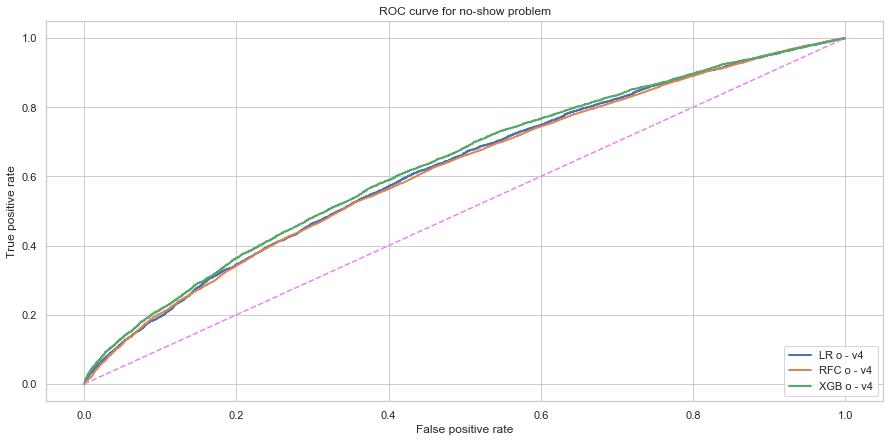

In [110]:
# Compare ROCs for:
fpr1, tpr1, thresholds1 = roc_curve(yv1_test, yv1_test_LR_prob) # LR
fpr2, tpr2, thresholds1 = roc_curve(yv1_test, yv1_test_KNN_prob) # KNN
fpr3, tpr3, thresholds1 = roc_curve(yv1_test, yv1_test_RFC_prob) # RFC
fpr4, tpr4, thresholds1 = roc_curve(yv1_test, yv1_test_XGB_prob) # XGB

fpr5, tpr5, thresholds1 = roc_curve(yv2_test, yv2_test_LR_prob) # LR
fpr6, tpr6, thresholds1 = roc_curve(yv2_test, yv2_test_KNN_prob) # KNN
fpr7, tpr7, thresholds1 = roc_curve(yv2_test, yv2_test_RFC_prob) # RFC
fpr8, tpr8, thresholds1 = roc_curve(yv2_test, yv2_test_XGB_prob) # XGB

fpr9, tpr9, thresholds9 = roc_curve(yv2_test, yv2_test_LR_o_prob) # LR
fpr10, tpr10, thresholds10 = roc_curve(yv2_test, yv2_test_RFC_o_prob) # RFC

fpr11, tpr11, thresholds11 = roc_curve(yv3_test, yv3_test_LR_o_prob) # LR
fpr12, tpr12, thresholds12 = roc_curve(yv3_test, yv3_test_RFC_o_prob) # RFC

fpr13, tpr13, thresholds13 = roc_curve(yv4_test, yv4_test_LR_o_prob) # LR
fpr14, tpr14, thresholds14 = roc_curve(yv4_test, yv4_test_RFC_o_prob) # RFC
fpr15, tpr15, thresholds15 = roc_curve(yv4_test, yv4_test_XGB_o_prob) # XGB

plt.figure(figsize=(15,7))
# plt.plot(fpr1, tpr1,lw=2,label='LR')
# plt.plot(fpr2, tpr2,lw=2,label='KNN')
# plt.plot(fpr3, tpr3,lw=2,label='RFC')
# plt.plot(fpr4, tpr4,lw=2,label='XGB')

# plt.plot(fpr5, tpr5,lw=2,label='LR - v2')
# plt.plot(fpr6, tpr6,lw=2,label='KNN - v2')
# plt.plot(fpr7, tpr7,lw=2,label='RFC - v2')
# plt.plot(fpr8, tpr8,lw=2,label='XGB - v2')

# plt.plot(fpr9, tpr9,lw=2,label='LR o - v2')
# plt.plot(fpr10, tpr10,lw=2,label='RFC o - v2')

# plt.plot(fpr11, tpr11,lw=2,label='LR o - v3')
# plt.plot(fpr12, tpr12,lw=2,label='RFC o - v3')

plt.plot(fpr13, tpr13,lw=2,label='LR o - v4')
plt.plot(fpr14, tpr14,lw=2,label='RFC o - v4')
plt.plot(fpr15, tpr15,lw=2,label='XGB o - v4')

plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.legend(loc='lower right')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for no-show problem');

In [131]:
print(f'LR - v1: {roc_auc_score(yv1_test, yv1_test_LR_prob):.3f}') # LR
print(f'KNN - v1: {roc_auc_score(yv1_test, yv1_test_KNN_prob):.3f}') # KNN
print(f'RFC - v1: {roc_auc_score(yv1_test, yv1_test_RFC_prob):.3f}') # RFC
print(f'XGB - v1: {roc_auc_score(yv1_test, yv1_test_XGB_prob):.3f}') # XGB

print(f'LR - v2: {roc_auc_score(yv2_test, yv2_test_LR_prob):.3f}') # LR
print(f'KNN - v2: {roc_auc_score(yv2_test, yv2_test_KNN_prob):.3f}') # KNN
print(f'RFC - v2: {roc_auc_score(yv2_test, yv2_test_RFC_prob):.3f}') # RFC
print(f'XGB - v2: {roc_auc_score(yv2_test, yv2_test_XGB_prob):.3f}') # XGB

print(f'LR o - v2: {roc_auc_score(yv2_test, yv2_test_LR_o_prob):.3f}') # LR
print(f'RFC o - v2: {roc_auc_score(yv2_test, yv2_test_RFC_o_prob):.3f}') # RFC
print(f'XGB o - v2: {roc_auc_score(yv2_test, yv2_test_XGB_o_prob):.3f}') # XGB

print(f'LR o - v3: {roc_auc_score(yv3_test, yv3_test_LR_o_prob):.3f}') # LR
print(f'RFC o - v3: {roc_auc_score(yv3_test, yv3_test_RFC_o_prob):.3f}') # RFC
print(f'XGB o - v3: {roc_auc_score(yv3_test, yv3_test_XGB_o_prob):.3f}') # XGB

print(f'LR o - v4: {roc_auc_score(yv4_test, yv4_test_LR_o_prob):.3f}') # LR
print(f'RFC o - v4: {roc_auc_score(yv4_test, yv4_test_RFC_o_prob):.3f}') # RFC
print(f'XGB o - v4: {roc_auc_score(yv4_test, yv4_test_XGB_o_prob):.3f}') # XGB

LR - v1: 0.591
KNN - v1: 0.572
RFC - v1: 0.603
XGB - v1: 0.612
LR - v2: 0.647
KNN - v2: 0.601
RFC - v2: 0.652
XGB - v2: 0.659
LR o - v2: 0.647
RFC o - v2: 0.653
XGB o - v2: 0.657
LR o - v3: 0.609
RFC o - v3: 0.607
XGB o - v3: 0.626
LR o - v4: 0.619
RFC o - v4: 0.615
XGB o - v4: 0.631


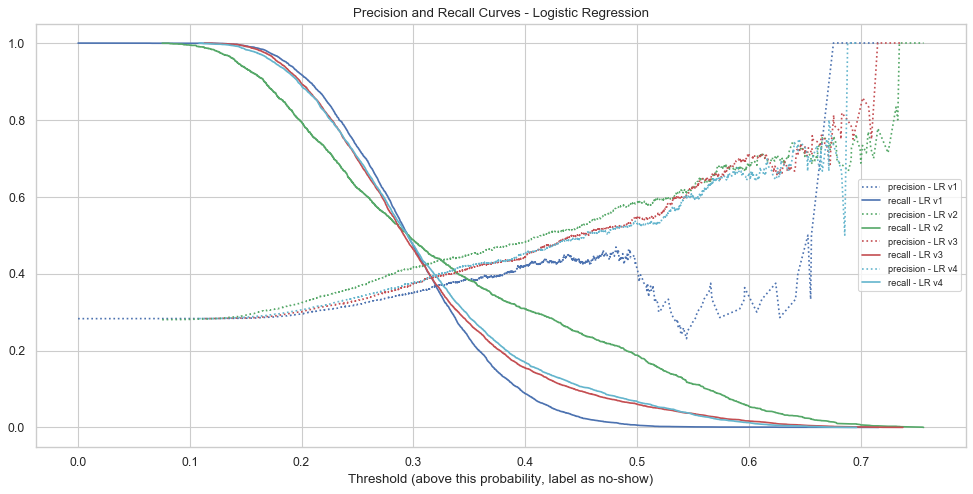

In [112]:
# Compare Precision/Recall curves
precision_curve1, recall_curve1, threshold_curve1 = precision_recall_curve(yv1_test, yv1_test_LR_prob)
precision_curve2, recall_curve2, threshold_curve2 = precision_recall_curve(yv2_test, yv2_test_LR_prob)
precision_curve3, recall_curve3, threshold_curve3 = precision_recall_curve(yv3_test, yv3_test_LR_prob)
precision_curve4, recall_curve4, threshold_curve4 = precision_recall_curve(yv4_test, yv4_test_LR_prob)

plt.figure(dpi=80,figsize=(15,7))
plt.plot(threshold_curve1, precision_curve1[1:],label='precision - LR v1',color='b',linestyle=':')
plt.plot(threshold_curve1, recall_curve1[1:], label='recall - LR v1',color='b')
plt.plot(threshold_curve2, precision_curve2[1:],label='precision - LR v2',color='g',linestyle=':')
plt.plot(threshold_curve2, recall_curve2[1:], label='recall - LR v2',color='g')
plt.plot(threshold_curve3, precision_curve3[1:],label='precision - LR v3',color='r',linestyle=':')
plt.plot(threshold_curve3, recall_curve3[1:], label='recall - LR v3',color='r')
plt.plot(threshold_curve4, precision_curve4[1:],label='precision - LR v4',color='c',linestyle=':')
plt.plot(threshold_curve4, recall_curve4[1:], label='recall - LR v4',color='c')
plt.legend(loc='center right',fontsize='small')
plt.xlabel('Threshold (above this probability, label as no-show)');
plt.title('Precision and Recall Curves - Logistic Regression');

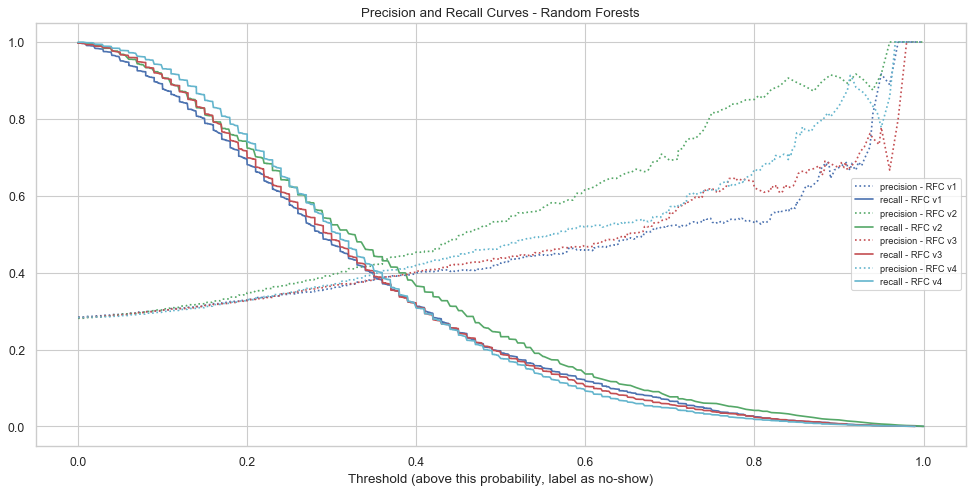

In [113]:
# Compare Precision/Recall curves
precision_curve1, recall_curve1, threshold_curve1 = precision_recall_curve(yv1_test, yv1_test_RFC_prob)
precision_curve2, recall_curve2, threshold_curve2 = precision_recall_curve(yv2_test, yv2_test_RFC_prob)
precision_curve3, recall_curve3, threshold_curve3 = precision_recall_curve(yv3_test, yv3_test_RFC_prob)
precision_curve4, recall_curve4, threshold_curve4 = precision_recall_curve(yv4_test, yv4_test_RFC_prob)

plt.figure(dpi=80,figsize=(15,7))
plt.plot(threshold_curve1, precision_curve1[1:],label='precision - RFC v1',color='b',linestyle=':')
plt.plot(threshold_curve1, recall_curve1[1:], label='recall - RFC v1',color='b')
plt.plot(threshold_curve2, precision_curve2[1:],label='precision - RFC v2',color='g',linestyle=':')
plt.plot(threshold_curve2, recall_curve2[1:], label='recall - RFC v2',color='g')
plt.plot(threshold_curve3, precision_curve3[1:],label='precision - RFC v3',color='r',linestyle=':')
plt.plot(threshold_curve3, recall_curve3[1:], label='recall - RFC v3',color='r')
plt.plot(threshold_curve4, precision_curve4[1:],label='precision - RFC v4',color='c',linestyle=':')
plt.plot(threshold_curve4, recall_curve4[1:], label='recall - RFC v4',color='c')
plt.legend(loc='center right',fontsize='small')
plt.xlabel('Threshold (above this probability, label as no-show)');
plt.title('Precision and Recall Curves - Random Forests');

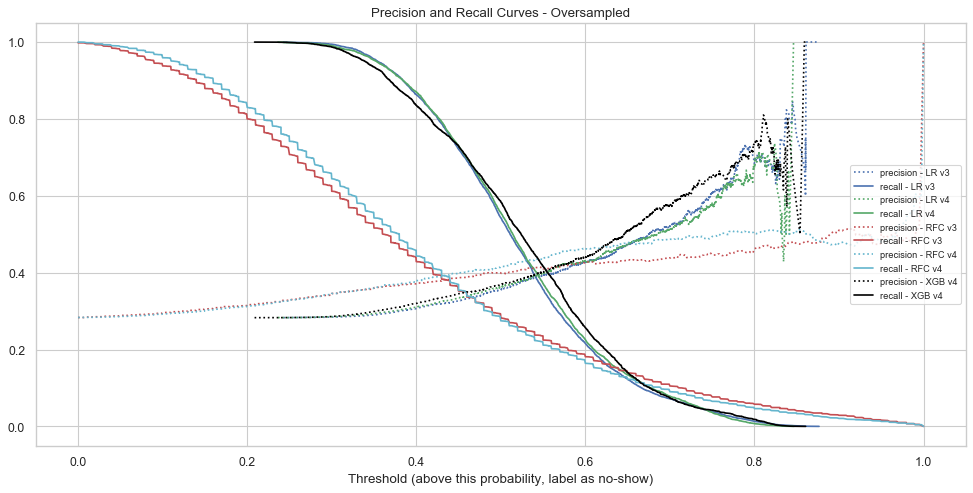

In [118]:
# Compare Precision/Recall curves
precision_curve1, recall_curve1, threshold_curve1 = precision_recall_curve(yv3_test, yv3_test_LR_o_prob)
precision_curve2, recall_curve2, threshold_curve2 = precision_recall_curve(yv4_test, yv4_test_LR_o_prob)
precision_curve3, recall_curve3, threshold_curve3 = precision_recall_curve(yv3_test, yv3_test_RFC_o_prob)
precision_curve4, recall_curve4, threshold_curve4 = precision_recall_curve(yv4_test, yv4_test_RFC_o_prob)
precision_curve5, recall_curve5, threshold_curve5 = precision_recall_curve(yv4_test, yv4_test_XGB_o_prob)


plt.figure(dpi=80,figsize=(15,7))
plt.plot(threshold_curve1, precision_curve1[1:],label='precision - LR v3',color='b',linestyle=':')
plt.plot(threshold_curve1, recall_curve1[1:], label='recall - LR v3',color='b')
plt.plot(threshold_curve2, precision_curve2[1:],label='precision - LR v4',color='g',linestyle=':')
plt.plot(threshold_curve2, recall_curve2[1:], label='recall - LR v4',color='g')
plt.plot(threshold_curve3, precision_curve3[1:],label='precision - RFC v3',color='r',linestyle=':')
plt.plot(threshold_curve3, recall_curve3[1:], label='recall - RFC v3',color='r')
plt.plot(threshold_curve4, precision_curve4[1:],label='precision - RFC v4',color='c',linestyle=':')
plt.plot(threshold_curve4, recall_curve4[1:], label='recall - RFC v4',color='c')
plt.plot(threshold_curve5, precision_curve5[1:],label='precision - XGB v4',color='black',linestyle=':')
plt.plot(threshold_curve5, recall_curve5[1:], label='recall - XGB v4',color='black')
plt.legend(loc='center right',fontsize='small')
plt.xlabel('Threshold (above this probability, label as no-show)');
plt.title('Precision and Recall Curves - Oversampled');

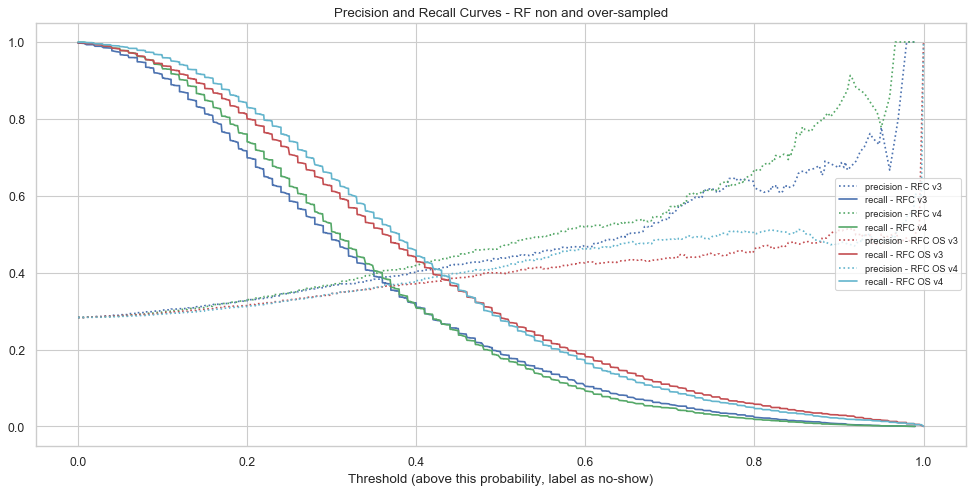

In [115]:
# Compare Precision/Recall curves
precision_curve1, recall_curve1, threshold_curve1 = precision_recall_curve(yv3_test, yv3_test_RFC_prob)
precision_curve2, recall_curve2, threshold_curve2 = precision_recall_curve(yv4_test, yv4_test_RFC_prob)
precision_curve3, recall_curve3, threshold_curve3 = precision_recall_curve(yv3_test, yv3_test_RFC_o_prob)
precision_curve4, recall_curve4, threshold_curve4 = precision_recall_curve(yv4_test, yv4_test_RFC_o_prob)

plt.figure(dpi=80,figsize=(15,7))
plt.plot(threshold_curve1, precision_curve1[1:],label='precision - RFC v3',color='b',linestyle=':')
plt.plot(threshold_curve1, recall_curve1[1:], label='recall - RFC v3',color='b')
plt.plot(threshold_curve2, precision_curve2[1:],label='precision - RFC v4',color='g',linestyle=':')
plt.plot(threshold_curve2, recall_curve2[1:], label='recall - RFC v4',color='g')
plt.plot(threshold_curve3, precision_curve3[1:],label='precision - RFC OS v3',color='r',linestyle=':')
plt.plot(threshold_curve3, recall_curve3[1:], label='recall - RFC OS v3',color='r')
plt.plot(threshold_curve4, precision_curve4[1:],label='precision - RFC OS v4',color='c',linestyle=':')
plt.plot(threshold_curve4, recall_curve4[1:], label='recall - RFC OS v4',color='c')
plt.legend(loc='center right',fontsize='small')
plt.xlabel('Threshold (above this probability, label as no-show)');
plt.title('Precision and Recall Curves - RF non and over-sampled');

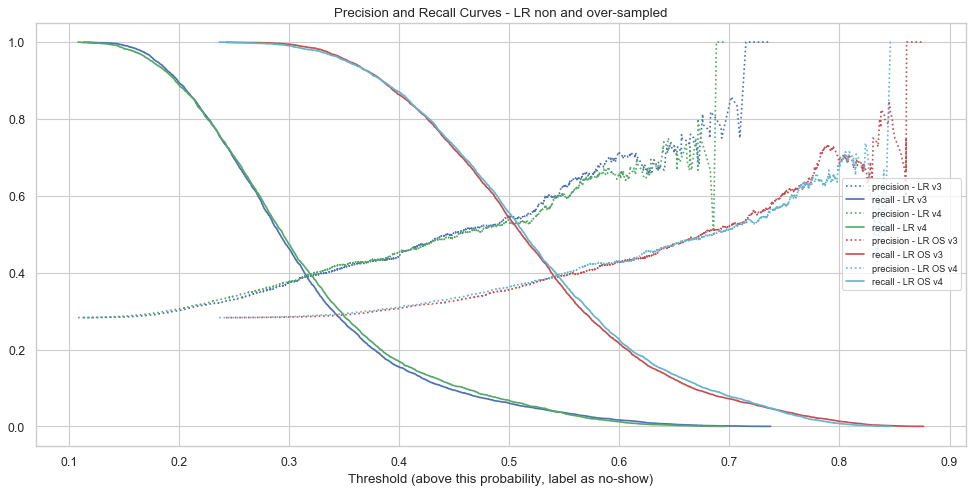

In [116]:
# Compare Precision/Recall curves
precision_curve1, recall_curve1, threshold_curve1 = precision_recall_curve(yv3_test, yv3_test_LR_prob)
precision_curve2, recall_curve2, threshold_curve2 = precision_recall_curve(yv4_test, yv4_test_LR_prob)
precision_curve3, recall_curve3, threshold_curve3 = precision_recall_curve(yv3_test, yv3_test_LR_o_prob)
precision_curve4, recall_curve4, threshold_curve4 = precision_recall_curve(yv4_test, yv4_test_LR_o_prob)

plt.figure(dpi=80,figsize=(15,7))
plt.plot(threshold_curve1, precision_curve1[1:],label='precision - LR v3',color='b',linestyle=':')
plt.plot(threshold_curve1, recall_curve1[1:], label='recall - LR v3',color='b')
plt.plot(threshold_curve2, precision_curve2[1:],label='precision - LR v4',color='g',linestyle=':')
plt.plot(threshold_curve2, recall_curve2[1:], label='recall - LR v4',color='g')
plt.plot(threshold_curve3, precision_curve3[1:],label='precision - LR OS v3',color='r',linestyle=':')
plt.plot(threshold_curve3, recall_curve3[1:], label='recall - LR OS v3',color='r')
plt.plot(threshold_curve4, precision_curve4[1:],label='precision - LR OS v4',color='c',linestyle=':')
plt.plot(threshold_curve4, recall_curve4[1:], label='recall - LR OS v4',color='c')
plt.legend(loc='center right',fontsize='small')
plt.xlabel('Threshold (above this probability, label as no-show)');
plt.title('Precision and Recall Curves - LR non and over-sampled');

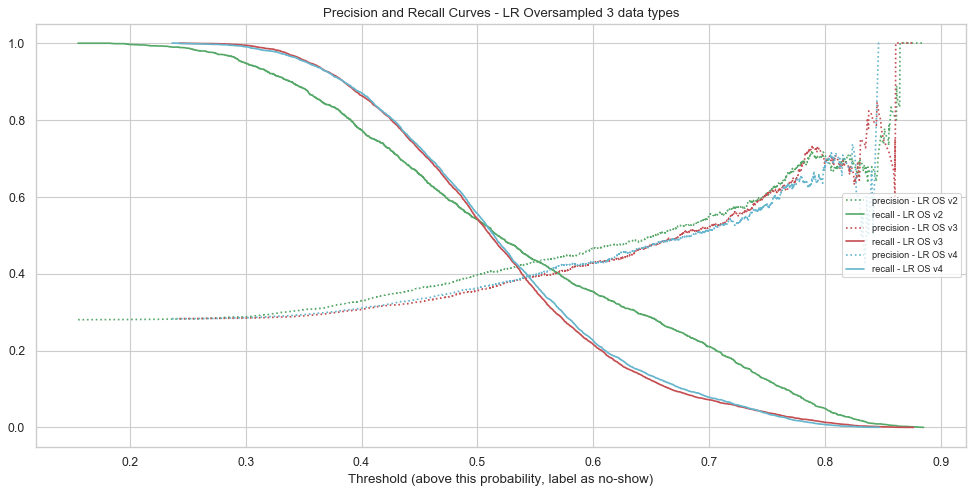

In [127]:
# Compare Precision/Recall curves
# precision_curve1, recall_curve1, threshold_curve1 = precision_recall_curve(yv3_test, yv3_test_LR_prob)
precision_curve2, recall_curve2, threshold_curve2 = precision_recall_curve(yv2_test, yv2_test_LR_o_prob)
precision_curve3, recall_curve3, threshold_curve3 = precision_recall_curve(yv3_test, yv3_test_LR_o_prob)
precision_curve4, recall_curve4, threshold_curve4 = precision_recall_curve(yv4_test, yv4_test_LR_o_prob)

plt.figure(dpi=80,figsize=(15,7))
# plt.plot(threshold_curve1, precision_curve1[1:],label='precision - LR v3',color='b',linestyle=':')
# plt.plot(threshold_curve1, recall_curve1[1:], label='recall - LR v3',color='b')
plt.plot(threshold_curve2, precision_curve2[1:],label='precision - LR OS v2',color='g',linestyle=':')
plt.plot(threshold_curve2, recall_curve2[1:], label='recall - LR OS v2',color='g')
plt.plot(threshold_curve3, precision_curve3[1:],label='precision - LR OS v3',color='r',linestyle=':')
plt.plot(threshold_curve3, recall_curve3[1:], label='recall - LR OS v3',color='r')
plt.plot(threshold_curve4, precision_curve4[1:],label='precision - LR OS v4',color='c',linestyle=':')
plt.plot(threshold_curve4, recall_curve4[1:], label='recall - LR OS v4',color='c')
plt.legend(loc='center right',fontsize='small')
plt.xlabel('Threshold (above this probability, label as no-show)');
plt.title('Precision and Recall Curves - LR Oversampled 3 data types');

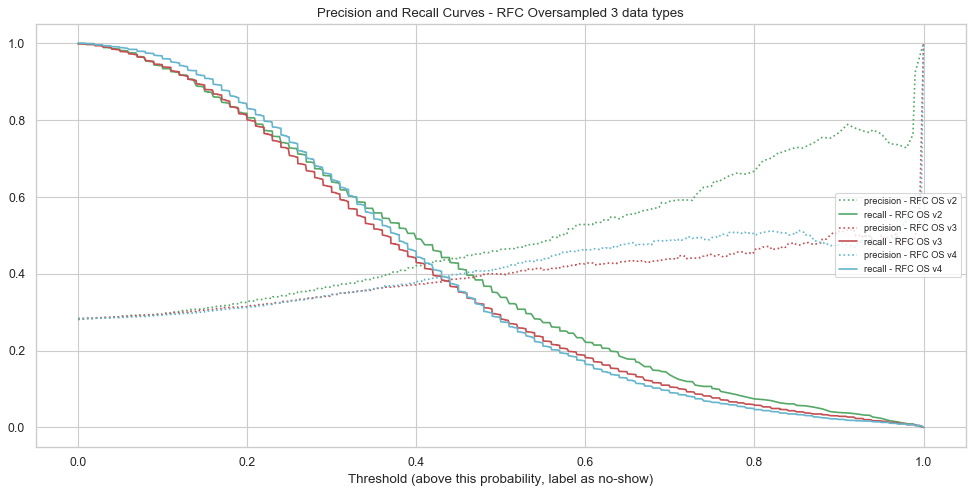

In [128]:
# Compare Precision/Recall curves
# precision_curve1, recall_curve1, threshold_curve1 = precision_recall_curve(yv3_test, yv3_test_LR_prob)
precision_curve2, recall_curve2, threshold_curve2 = precision_recall_curve(yv2_test, yv2_test_RFC_o_prob)
precision_curve3, recall_curve3, threshold_curve3 = precision_recall_curve(yv3_test, yv3_test_RFC_o_prob)
precision_curve4, recall_curve4, threshold_curve4 = precision_recall_curve(yv4_test, yv4_test_RFC_o_prob)

plt.figure(dpi=80,figsize=(15,7))
# plt.plot(threshold_curve1, precision_curve1[1:],label='precision - LR v3',color='b',linestyle=':')
# plt.plot(threshold_curve1, recall_curve1[1:], label='recall - LR v3',color='b')
plt.plot(threshold_curve2, precision_curve2[1:],label='precision - RFC OS v2',color='g',linestyle=':')
plt.plot(threshold_curve2, recall_curve2[1:], label='recall - RFC OS v2',color='g')
plt.plot(threshold_curve3, precision_curve3[1:],label='precision - RFC OS v3',color='r',linestyle=':')
plt.plot(threshold_curve3, recall_curve3[1:], label='recall - RFC OS v3',color='r')
plt.plot(threshold_curve4, precision_curve4[1:],label='precision - RFC OS v4',color='c',linestyle=':')
plt.plot(threshold_curve4, recall_curve4[1:], label='recall - RFC OS v4',color='c')
plt.legend(loc='center right',fontsize='small')
plt.xlabel('Threshold (above this probability, label as no-show)');
plt.title('Precision and Recall Curves - RFC Oversampled 3 data types');

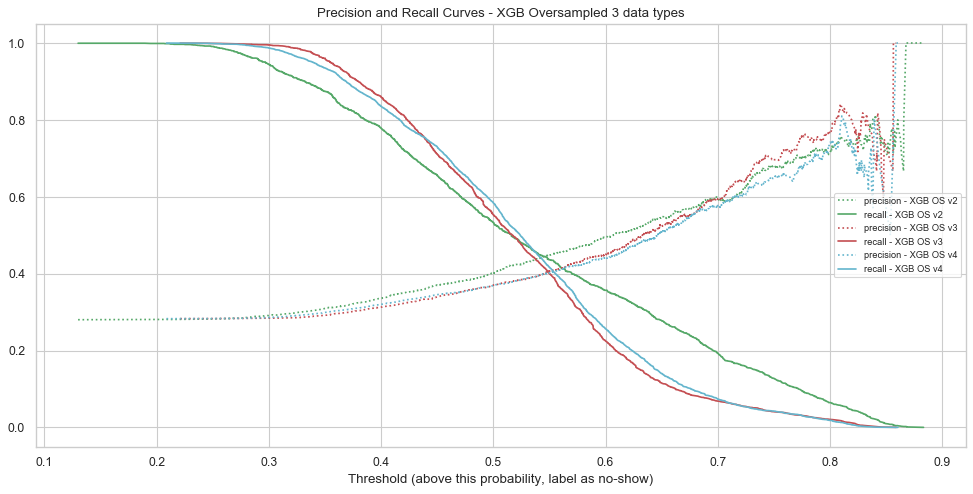

In [129]:
# Compare Precision/Recall curves
# precision_curve1, recall_curve1, threshold_curve1 = precision_recall_curve(yv3_test, yv3_test_LR_prob)
precision_curve2, recall_curve2, threshold_curve2 = precision_recall_curve(yv2_test, yv2_test_XGB_o_prob)
precision_curve3, recall_curve3, threshold_curve3 = precision_recall_curve(yv3_test, yv3_test_XGB_o_prob)
precision_curve4, recall_curve4, threshold_curve4 = precision_recall_curve(yv4_test, yv4_test_XGB_o_prob)

plt.figure(dpi=80,figsize=(15,7))
# plt.plot(threshold_curve1, precision_curve1[1:],label='precision - LR v3',color='b',linestyle=':')
# plt.plot(threshold_curve1, recall_curve1[1:], label='recall - LR v3',color='b')
plt.plot(threshold_curve2, precision_curve2[1:],label='precision - XGB OS v2',color='g',linestyle=':')
plt.plot(threshold_curve2, recall_curve2[1:], label='recall - XGB OS v2',color='g')
plt.plot(threshold_curve3, precision_curve3[1:],label='precision - XGB OS v3',color='r',linestyle=':')
plt.plot(threshold_curve3, recall_curve3[1:], label='recall - XGB OS v3',color='r')
plt.plot(threshold_curve4, precision_curve4[1:],label='precision - XGB OS v4',color='c',linestyle=':')
plt.plot(threshold_curve4, recall_curve4[1:], label='recall - XGB OS v4',color='c')
plt.legend(loc='center right',fontsize='small')
plt.xlabel('Threshold (above this probability, label as no-show)');
plt.title('Precision and Recall Curves - XGB Oversampled 3 data types');

LR has best AUC across all data types, XGB has slightly better recall